In [20]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import AllChem
import re
import torch
from torch_geometric.data import Data, Batch

from Bio.PDB import PDBList, PDBParser
from Bio import PDB

import networkx as nx
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GraphConv, GraphSAGE

import random

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

from ydata_profiling import ProfileReport
import os
import math
from scipy.stats import pearsonr

In [21]:
# 固定随机种子等操作
seed = 12345
print('seed is ' + str(seed))
g = torch.Generator()
g.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.use_deterministic_algorithms(True)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。


seed is 12345


# 1. read datasets

In [22]:
raw_data_BindingDB = pd.read_csv('./data/merged_data clean.csv')
raw_data_BindingDB

,ID,Smiles,IC50 (nM),canonical_smiles,Molecular Weight,LogP,num_H_acceptors,num_H_Donors
0,50952815,COc1ccc(NC(=O)N(CCCCC2CCCCC2)CCc2ccc(SC(C)(C)C...,0.28,COc1ccc(NC(=O)N(CCCCC2CCCCC2)CCc2ccc(SC(C)(C)C...,526.743,7.47770,4,2
1,50952818,CC(C)(Sc1ccc(CCN(CCCCC2CCCCC2)C(=O)NC2CCCCC2)c...,0.46,CC(C)(Sc1ccc(CCN(CCCCC2CCCCC2)C(=O)NC2CCCCC2)c...,502.765,7.27930,3,2
2,50952816,COc1cccc(NC(=O)N(CCCCC2CCCCC2)CCc2ccc(SC(C)(C)...,0.59,COc1cccc(NC(=O)N(CCCCC2CCCCC2)CCc2ccc(SC(C)(C)...,526.743,7.47770,4,2
3,50952817,COc1ccccc1NC(=O)N(CCCCC1CCCCC1)CCc1ccc(SC(C)(C...,1.90,COc1ccccc1NC(=O)N(CCCCC1CCCCC1)CCc1ccc(SC(C)(C...,526.743,7.47770,4,2
4,50332806,CC[C@@](C)(Cc1ccc(OCCCOc2ccc(cc2Cl)C2CCCCC2)cc...,2.00,CC[C@@](C)(Cc1ccc(OCCCOc2ccc(C3CCCCC3)cc2Cl)cc...,459.026,7.27900,3,1
...,...,...,...,...,...,...,...,...
1980,CHEMBL4575562,CCOc1ccc(-c2ccc(CCCc3nn(-c4ccc(S(C)(=O)=O)cc4)...,5040.00,CCOc1ccc(-c2ccc(CCCc3nn(-c4ccc(S(C)(=O)=O)cc4)...,629.710,5.43390,8,1
1981,CHEMBL3678128,Cc1c(C)n(Cc2ccc(Cl)c(O[C@@H](C)C(=O)O)c2)c2ccc...,935.00,Cc1c(C)n(Cc2ccc(Cl)c(O[C@@H](C)C(=O)O)c2)c2ccc...,561.122,7.60024,4,2
1982,CHEMBL510698,O=C(Nc1ccncc1)c1cc([N+](=O)[O-])ccc1Cl,2950.00,O=C(Nc1ccncc1)c1cc([N+](=O)[O-])ccc1Cl,277.667,2.89550,4,1
1983,CHEMBL5286386,CC(C)(O)c1ccc(NC(=O)c2cc(C(=O)NCc3ccc(F)c(F)c3...,16000.00,CC(C)(O)c1ccc(NC(=O)c2cc(C(=O)NCc3ccc(F)c(F)c3...,476.882,5.16700,3,3


In [23]:
raw_data_BindingDB.isna().sum()

ID                  0
Smiles              0
IC50 (nM)           0
canonical_smiles    0
Molecular Weight    0
LogP                0
num_H_acceptors     0
num_H_Donors        0
dtype: int64

In [24]:
raw_data_BindingDB.nunique()

ID                  1985
Smiles              1952
IC50 (nM)            639
canonical_smiles    1086
Molecular Weight     754
LogP                 845
num_H_acceptors        9
num_H_Donors           5
dtype: int64

In [25]:
raw_data_BindingDB.dtypes

ID                   object
Smiles               object
IC50 (nM)           float64
canonical_smiles     object
Molecular Weight    float64
LogP                float64
num_H_acceptors       int64
num_H_Donors          int64
dtype: object

In [26]:
change_type = raw_data_BindingDB['IC50 (nM)'].astype('float32')
raw_data_BindingDB['IC50 (nM)'] = change_type

In [27]:
raw_data_BindingDB['pIC50'] = raw_data_BindingDB['IC50 (nM)'].apply(lambda x: -np.log10(x * 10 ** (-9)))

In [28]:
raw_data_molecule_copy = raw_data_BindingDB[raw_data_BindingDB['pIC50'] >= 4.0]

In [29]:
raw_data_molecule = raw_data_molecule_copy.sample(frac=1, random_state=seed)
raw_data_molecule = raw_data_molecule.reset_index(drop=True)
raw_data_molecule

,ID,Smiles,IC50 (nM),canonical_smiles,Molecular Weight,LogP,num_H_acceptors,num_H_Donors,pIC50
0,CHEMBL1760268,CCCCN(c1cccc(-c2ccc(Cl)cc2)c1C)S(=O)(=O)c1ccc(...,6309.569824,CCCCN(c1cccc(-c2ccc(Cl)cc2)c1C)S(=O)(=O)c1ccc(...,516.059,6.39106,4,1,5.200000
1,CHEMBL238970,CCc1cc(OCC[C@@H](C)Oc2ccc(C(F)(F)F)cc2-c2ccccn...,6095.370117,CCc1cc(OCC[C@@H](C)Oc2ccc(C(F)(F)F)cc2-c2ccccn...,487.518,6.58340,4,1,5.215000
2,50077425,CCCCN(c1ccc(F)c(c1)-c1ccc(Cl)cc1)S(=O)(=O)c1cc...,19953.000000,CCCCN(c1ccc(F)c(-c2ccc(Cl)cc2)c1)S(=O)(=O)c1cc...,534.049,6.61024,4,1,4.699992
3,51241719,Fc1ccccc1-n1c(COc2ccc(cc2)-c2ccc(NS(=O)(=O)c3c...,38140.000000,O=c1n(-c2ccc(C(F)(F)F)cc2)nc(COc2ccc(-c3ccc(NS...,661.637,6.62290,8,1,4.418619
4,CHEMBL1947139,COc1ccc2c(-n3c(=O)n(Cc4ccc([C@@]5(C)OC(=O)NC5=...,50000.000000,COc1ccc2c(-n3c(=O)n(Cc4ccc([C@@]5(C)OC(=O)NC5=...,552.465,4.49070,9,1,4.301030
...,...,...,...,...,...,...,...,...,...
1976,CHEMBL597349,O=C(NCCCS(=O)(=O)c1ccc(C(F)(F)F)cn1)c1ccc(OC(F...,10000.000000,O=C(NCCCS(=O)(=O)c1ccc(C(F)(F)F)cn1)c1ccc(OC(F...,456.364,3.59280,5,1,5.000000
1977,50386699,Cc1nc(sc1COc1cc(Cl)c2c(CC(O)=O)csc2c1)-c1ccc(c...,1040.000000,Cc1nc(-c2ccc(C(F)(F)F)cc2)sc1COc1cc(Cl)c2c(CC(...,497.947,7.21152,5,1,5.982967
1978,CHEMBL460026,CC/C=C\C/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)O,1100.000000,CC/C=C\C/C=C\C/C=C\C/C=C\C/C=C\CCCC(=O)O,302.458,5.99270,1,1,5.958607
1979,CHEMBL498401,O=C(O)COc1cccc2c1CCN(S(=O)(=O)c1cccc(C(=O)Nc3c...,5011.870117,O=C(O)COc1cccc2c1CCN(S(=O)(=O)c1cccc(C(=O)Nc3c...,544.969,3.50090,6,3,5.300000


# 2. construct graphs for small molecules

In [30]:
# Define possible values for one-hot encoding
possible_atomic_numbers = list(range(1, 119))
possible_degrees = list(range(0, 10))
possible_hybridizations = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
possible_chirality = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER
]
possible_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
                       Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

possible_bond_stereo = [Chem.rdchem.BondStereo.STEREONONE, Chem.rdchem.BondStereo.STEREOZ,
                        Chem.rdchem.BondStereo.STEREOE, Chem.rdchem.BondStereo.STEREOCIS,
                        Chem.rdchem.BondStereo.STEREOTRANS]

# One-hot encoding functions
def one_hot_encode(value, possible_values):
    encoding = [0] * len(possible_values)
    if value in possible_values:
        encoding[possible_values.index(value)] = 1
    return encoding

# Functions for molecular data processing
def get_atomic_info(atom):
    atomic_number_encoding = one_hot_encode(atom.GetAtomicNum(), possible_atomic_numbers)
    degree_encoding = one_hot_encode(atom.GetTotalDegree(), possible_degrees)
    hybridization_encoding = one_hot_encode(atom.GetHybridization(), possible_hybridizations)
    aromatic_encoding = [1 if atom.GetIsAromatic() else 0]
    implicit_valence_encoding = one_hot_encode(atom.GetImplicitValence(), possible_degrees)
    formal_charge_encoding = [atom.GetFormalCharge()]
    chirality_encoding = one_hot_encode(atom.GetChiralTag(), possible_chirality)

    return atomic_number_encoding + degree_encoding + hybridization_encoding + \
           aromatic_encoding + implicit_valence_encoding + formal_charge_encoding + chirality_encoding

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = [get_atomic_info(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float)

    edges = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append((i, j))
        edges.append((j, i))

        bond_type_encoding = one_hot_encode(bond.GetBondType(), possible_bond_types)
        bond_stereo_encoding = one_hot_encode(bond.GetStereo(), possible_bond_stereo)
        conjugation_encoding = [1 if bond.GetIsConjugated() else 0]
        edge_feature = bond_type_encoding + bond_stereo_encoding + conjugation_encoding

        edge_features.append(edge_feature)
        edge_features.append(edge_feature)

    edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [31]:
graph_list = [smiles_to_graph(smile) for smile in raw_data_molecule['Smiles']]
pIC50_list = raw_data_molecule['pIC50'].to_list()

scaler = StandardScaler()
pIC50_list = scaler.fit_transform(np.array(pIC50_list).reshape(-1, 1)).flatten()

for graph, pIC50 in zip(graph_list, pIC50_list):
    graph.y = torch.tensor([pIC50], dtype=torch.float).view(-1, 1)


drug_graphs = graph_list
drug_graphs[0]


Data(x=[35, 149], edge_index=[2, 74], edge_attr=[74, 10], y=[1, 1])

# 3. construct graphs for protein

In [32]:
# Define a mapping from amino acid names to one-hot encoded vectors
amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLU', 'GLN', 'GLY', 'HIS', 'ILE', 
               'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
amino_acid_dict = {aa: idx for idx, aa in enumerate(amino_acids)}

In [33]:
def one_hot_encode_amino_acid(residue_name):
    one_hot = [0] * len(amino_acids)
    if residue_name in amino_acid_dict:
        one_hot[amino_acid_dict[residue_name]] = 1
    return one_hot


def pdb_to_graph(pdb_id):
    pdb_list = PDBList()
    pdb_file_path = pdb_list.retrieve_pdb_file(pdb_id, file_format='pdb', pdir='.')

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file_path)

    # Create a graph
    G = nx.Graph()

    # Traverse through the hierarchy
    for model in structure:
        for chain in model:
            for residue in chain:
                res_id = residue.get_id()
                residue_name = residue.get_resname()
                node_feature = one_hot_encode_amino_acid(residue_name)

                # Additional features: secondary structure and B-factor
                b_factor = residue["CA"].get_bfactor() if 'CA' in residue else 0.0
                
                # Combine all features
                node_feature.append(b_factor)

                G.add_node(res_id, residue_name=residue_name, feature=node_feature)

    # Add edges based on distance threshold
    threshold = 5.0  # Angstroms
    for residue1 in structure.get_residues():
        for residue2 in structure.get_residues():
            if residue1 != residue2:
                try:
                    distance = residue1['CA'] - residue2['CA']  # Using alpha carbon (CA) distance
                    if distance < threshold:
                        G.add_edge(residue1.get_id(), residue2.get_id(), distance=distance)
                except KeyError:
                    continue

    # Convert to PyTorch Geometric Data format
    data = from_networkx(G)

    # Convert node features to tensor and assign to data.x
    node_features = [G.nodes[n]['feature'] for n in G.nodes]
    data.x = torch.tensor(node_features, dtype=torch.float)

    # Optionally add edge attributes if necessary
    edge_attr = [G[u][v]['distance'] for u, v in G.edges]
    data.edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)


    return data

In [34]:
protein_pdb = '2ZNP'
protein_graph = pdb_to_graph(protein_pdb)
protein_graph

Structure exists: '.\pdb2znp.ent' 


Data(edge_index=[2, 714], residue_name=[275], feature=[275, 21], distance=[714], num_nodes=275, x=[275, 21], edge_attr=[357, 1])

# 4. datasets preparation

shuffling the dataset before it is split can improve the performance. When downloading the dataset from CheMBL, the compound may be sorted and ranked. 

In [35]:
batch_size = 64
torch.manual_seed(seed)
drug_graph_train_loader = DataLoader(drug_graphs[0: int(len(drug_graphs) * 0.8)], batch_size=batch_size, shuffle=True)
drug_graph_test_loader = DataLoader(drug_graphs[int(len(drug_graphs) * 0.2): ], batch_size=batch_size, shuffle=False)

# 5. model construction

In [36]:
class GCN_Graph(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_Graph, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)

        x = global_mean_pool(x, batch)  # Global pooling

        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.lin(x)

        return x


class AffinityPredictor(torch.nn.Module):
    def __init__(self, protein_gnn, molecule_gnn, hidden_channels):
        super(AffinityPredictor, self).__init__()
        torch.manual_seed(seed)
        self.protein_gnn = protein_gnn
        self.molecule_gnn = molecule_gnn
        self.lin = torch.nn.Linear(hidden_channels * 2, hidden_channels * 2)
        self.batch = torch.nn.BatchNorm1d(hidden_channels * 2)
        self.fc = torch.nn.Linear(hidden_channels * 2, 1)
    
    def forward(self, protein_data, molecule_data):
        # Protein embedding
        protein_embedding = self.protein_gnn(protein_data.x, protein_data.edge_index, protein_data.batch)
        protein_embedding = protein_embedding.unsqueeze(0).expand(molecule_data.batch.max().item() + 1, -1, -1)  # Expand for batch size
        protein_embedding = protein_embedding.reshape(-1, protein_embedding.size(-1))  # Reshape to match molecule_embedding
        # Molecule embedding
        molecule_embedding = self.molecule_gnn(molecule_data.x, molecule_data.edge_index, molecule_data.batch)
        
        # Concatenate embeddings
        x = torch.cat([protein_embedding, molecule_embedding], dim=1)
        x = self.lin(x)
        x = self.batch(x)
        x = F.leaky_relu(x)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        return self.fc(x)


# 6. initializing the model

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
protein_gnn = GCN_Graph(in_channels=protein_graph.num_node_features, hidden_channels=128, out_channels=128).to(device)
molecule_gnn = GCN_Graph(in_channels=drug_graphs[0].num_node_features, hidden_channels=128, out_channels=128).to(device)
model = AffinityPredictor(protein_gnn, molecule_gnn, hidden_channels=128).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = torch.nn.L1Loss(reduction='mean').to(device)

Using device: cuda


# 7. train and test
rule of thumb: either MAE < 0.6 or R2 > 0.6 is considered as good model
https://www.nature.com/articles/s41598-020-80113-7

In [38]:
def train(model, protein_graph, drug_graph_train_loader, optimizer, criterion, epoch):
    model.train()

    for molecule_data in drug_graph_train_loader:
        
        optimizer.zero_grad()
        molecule_data = molecule_data.to(device)
        protein_graph = protein_graph.to(device)
        
        protein_graph_batch = protein_graph.clone()
        protein_graph_batch.batch = torch.zeros(protein_graph.x.size(0), dtype=torch.long).to(device)
        
        output = model(protein_graph, molecule_data)
        loss = criterion(output, molecule_data.y)
        loss.backward()
        optimizer.step()
    

def test(protein_graph, loader):
    model.eval()

    loss_list = []
    r2_list = []

    with torch.no_grad():
        for data in loader:
            
            protein_graph = protein_graph.to(device)
            data = data.to(device)
            out = model(protein_graph, data)
   
            out = torch.tensor(scaler.inverse_transform(out.detach().cpu().numpy().reshape(-1, 1)).flatten())
            actual = torch.tensor(scaler.inverse_transform(data.y.detach().cpu().numpy().reshape(-1, 1)).flatten())

            mae_loss = criterion(out, actual)

            r2 = r2_score(actual, out)
            r2_list.append(r2)

            mae_loss = mae_loss.detach().cpu().numpy()
            loss_list.append(mae_loss)
            
    return loss_list, r2_list
        
overall_train_r2 = []
overall_test_r2 = []
overall_train_loss = []
overall_test_loss = []

best_loss = float('inf')
patience = 100
patience_counter = 0
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
# Training loop
for epoch in range(1, 2001):
    train(model,protein_graph, drug_graph_train_loader, optimizer, criterion, epoch)

    if epoch % 1 == 0:
        train_loss, r2_train_list = test(protein_graph, drug_graph_train_loader)
        test_loss, r2_test_list = test(protein_graph, drug_graph_test_loader)
        print(f'Epoch {epoch}, MAE train loss: {np.average(train_loss):.4f}, MAE test loss: {np.average(test_loss):.4f}, train r2: {np.average(r2_train_list):.4f}, test r2: {np.average(r2_test_list):.4f}')

        overall_train_loss.append(np.average(train_loss))
        overall_test_loss.append(np.average(test_loss))

        overall_train_r2.append(np.average(r2_train_list))
        overall_test_r2.append(np.average(r2_test_list))


        if np.average(test_loss) < best_loss:
            best_loss = np.average(test_loss)
            patience_counter = 0
            # torch.save(model.state_dict(), 'best_model_no_fingerprint_GraphConv_Combined.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping")
            break
    scheduler.step()

Epoch 1, MAE train loss: 0.8195, MAE test loss: 0.8168, train r2: 0.0442, test r2: 0.0258
Epoch 2, MAE train loss: 0.6759, MAE test loss: 0.6819, train r2: 0.3126, test r2: 0.2799
Epoch 3, MAE train loss: 0.6463, MAE test loss: 0.6525, train r2: 0.3034, test r2: 0.2800
Epoch 4, MAE train loss: 0.6301, MAE test loss: 0.6379, train r2: 0.3518, test r2: 0.3200
Epoch 5, MAE train loss: 0.6169, MAE test loss: 0.6289, train r2: 0.3238, test r2: 0.2860
Epoch 6, MAE train loss: 0.5945, MAE test loss: 0.6091, train r2: 0.4192, test r2: 0.3737
Epoch 7, MAE train loss: 0.6042, MAE test loss: 0.6199, train r2: 0.4078, test r2: 0.3656
Epoch 8, MAE train loss: 0.5782, MAE test loss: 0.5875, train r2: 0.4045, test r2: 0.3880
Epoch 9, MAE train loss: 0.5722, MAE test loss: 0.5852, train r2: 0.4418, test r2: 0.4133
Epoch 10, MAE train loss: 0.7800, MAE test loss: 0.7802, train r2: 0.0561, test r2: 0.0307
Epoch 11, MAE train loss: 0.5438, MAE test loss: 0.5597, train r2: 0.4684, test r2: 0.4432
Epoch 12

In [39]:
print('r2 on testset', np.average(overall_test_r2[400:]))
print('MAE on testset',np.average(overall_test_loss[400:]))

r2 on testset 0.7471807638114593
MAE on testset 0.32734004


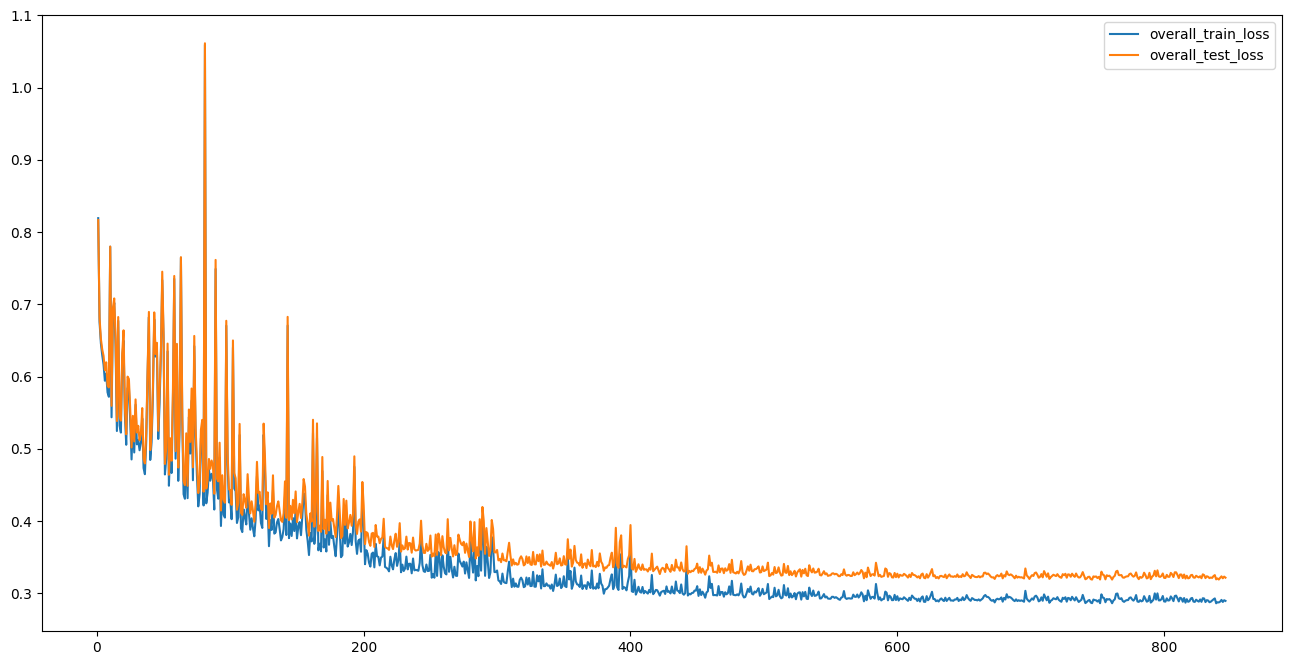

In [41]:
x = [i for i in range(1, 847)]
fig = plt.figure(figsize=(16, 8))
plt.plot(x, overall_train_loss, label = 'overall_train_loss')
plt.plot(x, overall_test_loss, label = 'overall_test_loss')
plt.legend()
plt.show() 
# fig.savefig('./mae_no_fingerprint_GraphConv_Combined.png')

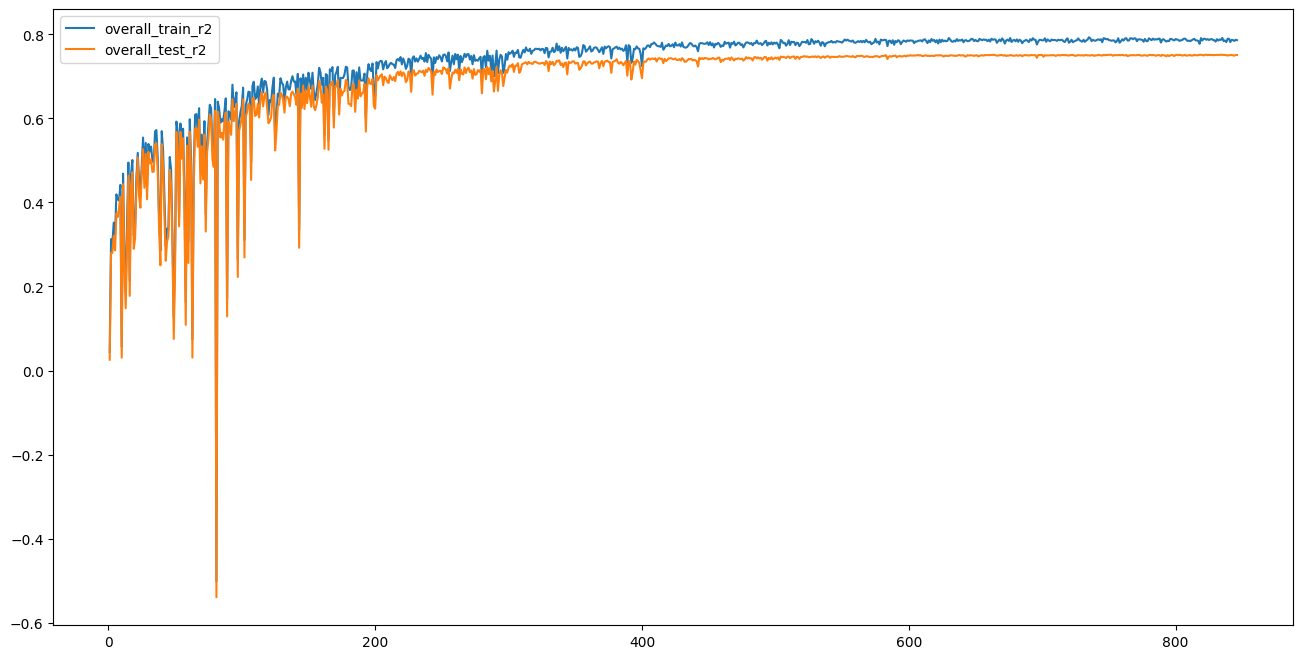

In [42]:
fig = plt.figure(figsize=(16, 8))
plt.plot(x, overall_train_r2, label = 'overall_train_r2')
plt.plot(x, overall_test_r2, label = 'overall_test_r2')
plt.legend()
plt.show()
# fig.savefig('./r2_no_fingerprint_GraphConv_Combined.png')